# Adjusting for Cell Doubling Time in Viability Data


In [1]:
# Install dependencies
# install cmapPy
!pip install -q cmapPy
# download workshop data
!wget --quiet -O - https://s3.amazonaws.com/repo-assets.clue.io/lincswkshp20_pfc_assets.tgz|tar zx -C .

import warnings
warnings.filterwarnings("ignore")
import os.path
import pandas as pd
from cmapPy.pandasGEXpress import parse as pe
import cmapPy.pandasGEXpress.GCToo as GCToo
import cmapPy.pandasGEXpress.write_gctx as wgx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import string
import matplotlib
# print Pandas df as formatted tables
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Plotting defaults
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
matplotlib.rcParams['figure.figsize'] = [8, 6]

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

In [2]:
BASE_PATH = './assets'

# Empirically derived Cell growth parameters
cell_info_all = pd.read_table(os.path.join(BASE_PATH, 'PRISM_cell_growth_metrics.txt'), dtype={'feature_id': str})
cell_info_all.set_index('feature_id', inplace=True)

# Unadjusted Signatures
gct = pe.parse(os.path.join(BASE_PATH, 'PGR001_LEVEL5_MODZ.LFCPC.COMBAT_n128x489.gctx'))
sig_metrics = pd.read_table(os.path.join(BASE_PATH, 'PGR001_sig_metrics_MODZ.LFCPC.COMBAT.txt'))

# Adjusted Signatures
adj_gct = pe.parse(os.path.join(BASE_PATH, 'PGR001_LEVEL5_MODZ.GRAP.COMBAT_n128x489.gctx'))

In [3]:
cell_info = cell_info_all[cell_info_all['t_doubling']<=120]

We'll be looking at how cell doubling time correlates with how frequently that line is called as a "hit" in PRISM data.

We calculated the doubling time using a timepoint 0 plate.

Let's take a look at the distribution of doubling times. 

Text(0.5, 1.0, 'Distribution of Empirical Doubling Times for 457 Pr500 Cell lines')

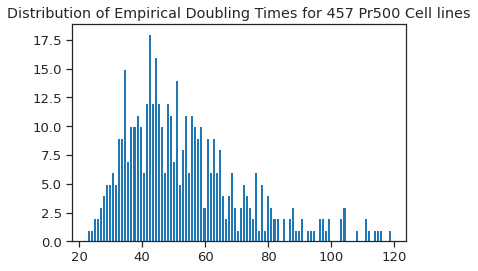

In [4]:
n,b,p = plt.hist(cell_info['t_doubling'], 100)
plt.title('Distribution of Empirical Doubling Times for %d Pr500 Cell lines' % cell_info.shape[0])
plt.show()

Looks like most of the cell lines fall between 1 and 5 days.

Let's see how they compare against other values which have been calculated for the same lines. We're going to scatter our doubling times against reference doubling times for the same lines. 

First let's define a function to calculate the r2

In [5]:
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

There are columns for our doubling times and for the reference in the cell info. Let's scatter them against each other.

Text(0.5, 0.98, 'Empirical Doubling Times vs Reference')

(0.0, 120.0)

(0.0, 120.0)

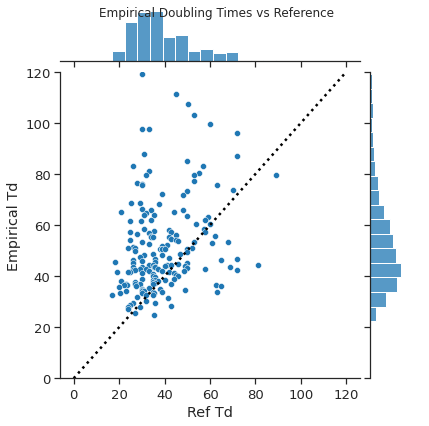

In [6]:
g = sns.jointplot(cell_info['t_doubling_reference'].rename('Ref Td'), cell_info['t_doubling'].rename('Empirical Td'))
g.fig.suptitle('Empirical Doubling Times vs Reference')
lims = [0,120]
g.ax_joint.plot(lims, lims, ':k')  
plt.ylim(0,120)
plt.xlim(0,120)
plt.show()

Some differences, certainly. 

Now let's check them against DNA Sequencing Estimates.

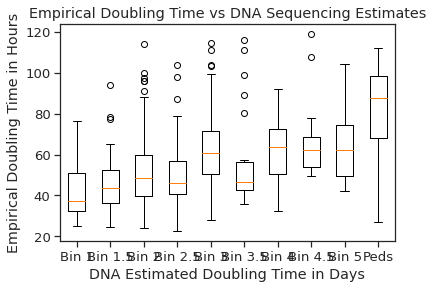

In [15]:
data = []
labels = []
for bins in pd.Series(cell_info['bin_doubling_time_days'].unique()).sort_values():
    temp  = cell_info[cell_info['bin_doubling_time_days'] == bins]
    data.append(temp['t_doubling'])
    labels.append(bins)
    
_ = plt.boxplot(data, labels=labels)
_ = plt.title('Empirical Doubling Time vs DNA Sequencing Estimates')
_ = plt.xlabel('DNA Estimated Doubling Time in Days')
_ = plt.ylabel('Empirical Doubling Time in Hours')
plt.show()

These seem to correlate a little better.

Now let's see how cell doubling time affects hit frequency.

We'll be reading in data from our PGR dataset. 

Let's calculate hit frequency.

The threshold we generally use when calling hits is a z-score of -2, thought this can be played with.

We will simply calculate the % of signatures which were called as a hit for each cell line

In [16]:
data = gct.data_df.loc[cell_info.index]

#Count values
hit_threshold = -2
hit_freq = (data[data < hit_threshold].count(axis=1) / data.shape[1]) * 100

Now let's scatter hit frequency against doubling time, and let's use that function we defined earlier for calculating R2.

Text(0.5, 0.98, 'Doubling Time vs Signature Hit Frequency')

(0.0, 30.0)

(20.0, 120.0)

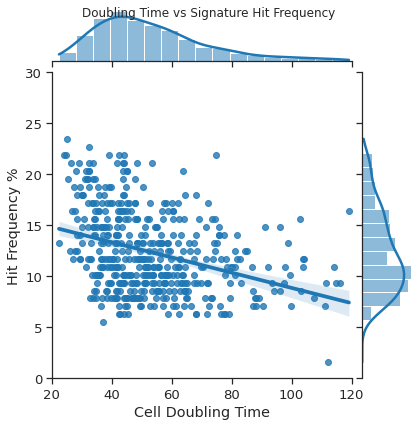

In [17]:
g = sns.jointplot(cell_info['t_doubling'].rename('Cell Doubling Time'), hit_freq.rename('Hit Frequency %'), kind="reg")
g.fig.suptitle('Doubling Time vs Signature Hit Frequency')
plt.ylim(0,30)
plt.xlim(20,120)
plt.show()

There definitely appears to be a relationship here. Cell lines with shorter doubling times are called more frequently. 

Now let's see what this looks like when we use data that has been adjusted for its doubling time. We'll be reading in a new dataset and making the exact same plot

In [18]:
adj_data = adj_gct.data_df.loc[cell_info.index]
hit_freq = (adj_data[adj_data < -2].count(axis=1) / adj_data.shape[1]) * 100

Text(0.5, 0.98, 'Doubling Time vs Hit Frequency for PRISM Data')

(0.0, 30.0)

(20.0, 120.0)

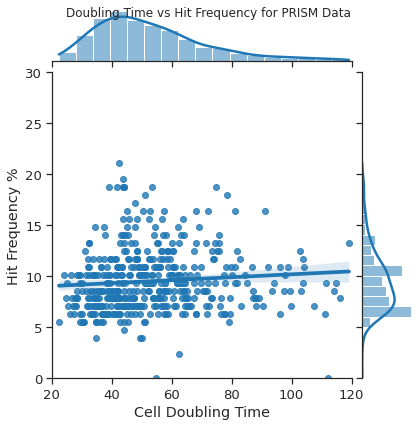

In [19]:
g = sns.jointplot(cell_info['t_doubling'].rename('Cell Doubling Time'), hit_freq.rename('Hit Frequency %'), kind="reg")
g.fig.suptitle('Doubling Time vs Hit Frequency for PRISM Data')
plt.ylim(0,30)
plt.xlim(20,120)
plt.show()

- Show r2 and Corr
- Have datasets fixed upfront. Str index. Correct size. 72H
- dist of doubling time
- scatter of td against reference bins